In [46]:
# import libraries
import pandas as pd
import numpy as np
import time
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
pd.plotting.register_matplotlib_converters()

import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import precision_recall_curve


from sklearn.linear_model import Lasso, LogisticRegression
# from sklearn.metrics import accuracy_score,make_scorer, mean_squared_error, mean_absolute_error,

from sklearn import datasets, linear_model, metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier


import scikitplot as skplt
from sklearn import tree

## I. DATA Processing

https://www.kaggle.com/henriqueyamahata/bank-marketing

### Những chú ý cho quá trình xử lý

1. Lược bỏ dữ liệu
* Vẫn lấy duration ((Cột 'duration' sẽ không được quan tâm trong quá trình phân tích và xử lý))
* Có 12 dòng trùng nhau sẽ cắt bỏ
2. Missing:
* các giá trị unknown của các cột khác: loan, housing, default, marital, job
3. Outlier:
* Age, campain, previous, cons.conf.idx
4. Phân loại lại biến pdays, age
5. Clustering theo 3 chỉ số pdays,previous,poutcome
6. Sự tương quan giữa các biến:
* Vẫn lấy cả 3 biến ((3 biến nr.employed, emp.var.rate, euribo3m là 3 biến có tương quan rất mạnh --> có thể lọc bớt để giảm chiều dữ liệu))


### Cách xử lý
1. Xóa 12 dòng dữ liệu trùng nhau
2. Không bỏ cột nào((Loại bỏ cột duration, nr.employed))
3. Biến 'default': khoảng 20% biến này có giá trị 'unknown' - không xác định đc là client có tín dụng xấu hay không - (yes) hay (no).
> Vì đa số biến này cũng khó xác định nên ta sẽ không biến đổi thuộc tính này

MISSING
4. 2. Biến 'education': 4% là unknown
> Thay thế giá trị 'unknown' --> 'university-degree'(bằng giá trị mode của cột dữ liệu)
5. Biến 'loan' và 'housing': 
    * Tỉ lệ missing khá nhỏ: là 2.4% (unknown)
    * Cách xử lý: mục tiêu là càng tiếp thị càng nhiều khách hàng càng tốt, ta đánh vào các giá trị mà tỉ lệ sucessful cao:
        - loan : unknown --> no
        - housing: unknown --> yes
6. Biến marital:missing rất thấp 0.1%
> unknown --> single
7. Biến job: missing thấp 0.8
> unknown --> student

OUTLIER
8. (I). age: thay thế những giá trị > 70 bằng 70
Nhìn biểu đồ thấy sau 70 là outlier
9. (II). campain: thay thế những giá trị > quantile_95 bằng quantile_95
10. (III). previous: thay thế những giá trị > quantile_95 bằng quantile_95
11. (IV). cons.conf.idx: thay thế những giá trị > quantile_95 bằng quantile_95
12. (IIV). Duration: thay thế outlier sau giá trị 1500 bằng 1500 (con số này lấy từ mô hình EDA)

Phân loại lại biến
12. (I). Column 'pdays'
* Có đến 96.3% bộ dữ liệu thuộc tính 'pdays' có giá trị '999' - ghi nhận lại đây là những khách hàng chưa được liên hệ bằng call trước đó.
> Vì vậy đối với biến này, ta sẽ biến đổi phân loại thành 3 nhóm: 'not_previously_contacted', 'within_a_week', 'over_a_week'

In [28]:
def remove_duplicated_row(df):
    df = df.drop(df[df.duplicated()].index).reset_index(drop=True)
    return(df)

def remove_features(df,col_lst):
    for col in col_lst:
        df.pop(col)
    return(df)

def replace_missing_by_value(df,column,replaced_value,missing_value='unknown'):
    df[column] = df[column].apply(lambda val: replaced_value if val == missing_value else val)
    return df

def replace_outlier_by_quantile(df, column, quantile_thresh = 0.95, replaced_value = None):
    thresh_value = df[column].quantile(quantile_thresh)
    if (replaced_value == None):
        replaced_value = thresh_value
        
    df[column] = df[column].apply(lambda val: replaced_value if val > thresh_value  else val)
    return df

def replace_outlier_by_value(df, column, value_thresh, replaced_value = None):
    if (replaced_value == None):
        replaced_value = value_thresh
        
    df[column] = df[column].apply(lambda val: replaced_value if val > value_thresh else val)
    return df

def replace_missing_by_mode(df,column,missing_value='unknown'):
    replaced_value = df[column].mode().values.tolist()[0]
    df[column] = df[column].apply(lambda val: replaced_value if val == missing_value else val)
    
    return df

def replace_missing_by_median(df,column,missing_value='unknown'):
    replaced_value = df[column].median().values.tolist()[0]
    df[column] = df[column].apply(lambda val: replaced_value if val == missing_value else val)
    return df

def transform_pdays(val):
    transform_dict = {999:'not_previously_contacted',7: 'over_a_week',0:'within_a_week'}
    for key in transform_dict.keys():
        if (val >= key):
            return transform_dict[key]

def eval_class(true, predicted):
    acc = metrics.accuracy_score(true, predicted)
    precision = metrics.precision_score(true, predicted)
    recall = metrics.recall_score(true, predicted)
    f1 = metrics.f1_score(true, predicted)
    log_loss = metrics.log_loss(true, predicted)
    auc = metrics.roc_auc_score(true, predicted)
    return acc, precision, recall, f1, log_loss, auc

def create_evaluation_df(model_name, y_train,y_train_pred, y_test, y_test_pred):
    eval_clm_metrics = ['Accuracy', 'Precision', 'Recall', 'F1', 'Log_loss','AUC']
    eval_clm_train = [m + '_train' for m in eval_clm_metrics]
    eval_clm_test = [m + '_test' for m in eval_clm_metrics]
    dis_clm = ['Model','Accuracy_train'] + eval_clm_test + ['diff_Acc_train_test']
    dis_clm_1 = ['Model','Accuracy_train','Accuracy_test','Precision_test','Recall_test','F1_test']
  
    res_clm = pd.DataFrame(data=[[model_name,*eval_class(y_train,y_train_pred),
                                 *eval_class(y_test, y_test_pred)]],
                          columns=['Model'] + eval_clm_train + eval_clm_test)
    res_clm['diff_Acc_train_test'] = res_clm.apply(lambda x: (x.Accuracy_test - x.Accuracy_train)/x.Accuracy_train, axis=1)
    
    return(res_clm[dis_clm_1])

def init_evaluation_df():
    eval_clm_metrics = ['Accuracy', 'Precision', 'Recall', 'F1', 'Log_loss','AUC']
    eval_clm_train = [m + '_train' for m in eval_clm_metrics]
    eval_clm_test = [m + '_test' for m in eval_clm_metrics]
    dis_clm = ['Model','Accuracy_train'] + eval_clm_test + ['diff_Acc_train_test']
    dis_clm_1 = ['Model','Accuracy_train','Accuracy_test','Precision_test','Recall_test','F1_test']
    
    res_clm = pd.DataFrame( columns=['Model'] + eval_clm_train + eval_clm_test + ['diff_Acc_train_test'])

    return(res_clm[dis_clm_1])
        
def data_processing_pipeline(df):
    # remove duplicated rows
    df = remove_duplicated_row(df)
    
    # remove duration and nr.employed
#     remove_cols =['duration', 'nr.employed'] 
#     df = remove_features(df,remove_cols)
    
    # edu_unknown = 'unknown'
    column = 'education'
    replaced_value = df[column].mode().values.tolist()[0]
    df = replace_missing_by_value(df,column,replaced_value)

    # housing_unknown = 'unknown'
    column = 'housing'
    replaced_value  = 'yes' #df[column].mode().values.tolist()[0]
    df = replace_missing_by_value(df,column,replaced_value)

    # loan_unknown = 'unknown'
    column = 'loan'
    replaced_value  = 'no' # df[column].mode().values.tolist()[0]
    df = replace_missing_by_value(df,column,replaced_value)

    # marital_unknown = 'unknown'
    column = 'marital'
    replaced_value  = 'single' # df[column].mode().values.tolist()[0]
    df = replace_missing_by_value(df,column,replaced_value)

    # job_unknown = 'unknown'
    column = 'job'
    replaced_value  = 'student' # df[column].mode().values.tolist()[0]
    df = replace_missing_by_value(df,column,replaced_value)

    ## OUTlier
    # age
    value_thresh = 65
    column = 'age' 
    df = replace_outlier_by_value(df,column,value_thresh)

    # duration
    column = 'duration' 
    df =  replace_outlier_by_quantile(df, column)# replace by quantile_95
    
    # campain
    value_thresh = 6
    column = 'campaign' 
    df = replace_outlier_by_value(df,column,value_thresh)

    #previous
    remove_thresh = float(0.95)
    column = 'previous' 
    df = replace_outlier_by_quantile(df,column)

    #cons.conf.idx'
    remove_thresh = float(0.95)
    column = 'cons.conf.idx' 
    df = replace_outlier_by_quantile(df,column)

    ### PHÂN LOẠI LẠI BIẾN
    # pdays
    column = 'pdays'
    df[column] = df[column].map(transform_pdays)
    
    return df

def label_encode_pipeline(df, cat_col_lst):
    labelencoder = LabelEncoder()
    for column in cat_col_lst:
        df[column] = labelencoder.fit_transform(df[column])
    return(df)

def run_model(name,model, X_train, y_train, X_test, y_test):
    # model_eval_df : evaluation dataframe of model
    # y_test_pred_proba: kiểu np.array - dùng để vẽ roc curve
    
    train_model_time = 0 # đo thời gian chạy model
    model_eval_df = pd.DataFrame() # evaluation dataframe
    start_time = time.time()
    
    model.fit(X_train,y_train)
    
    end_time = time.time()
    y_test_pred = model.predict(X_test)
    y_test_pred_proba = model.predict_proba(X_test)[:,1] #Lấy xác suất phần 1 
    y_train_pred = model.predict(X_train)

    model_eval_df = create_evaluation_df(name, y_train,y_train_pred, y_test, y_test_pred)
    train_model_time =  end_time - start_time
    return(model_eval_df,y_test_pred_proba)    

def run_model_lst(name_lst,model_lst, X_train, y_train, X_test, y_test):
    evalutation_df = init_evaluation_df() # evaluation dataframe
    y_test_proba_df = pd.DataFrame() # y_test_proba for ROC curve

    for model,name in zip(model_lst,name_lst):
        model_eval_df,y_test_pred_proba = run_model(name,model, X_train, y_train, X_test, y_test)
        
        evalutation_df = evalutation_df.append(model_eval_df, ignore_index = True)
        y_test_proba_df[name] = y_test_pred_proba
    
    return(evalutation_df,y_test_proba_df)

### ROC CURVE

def visualize_ROC_curves(y_test,y_pred_proba_df):
    plt.figure(figsize = (15,6))
    plt.plot([0, 1], [0, 1], 'k--')

    # Generate ROC curve values: fpr, tpr, thresholds
    for col in y_pred_proba_df.columns:
        fpr1, tpr1, thresholds1 = metrics.roc_curve(y_test, y_pred_proba_df[col])
        plt.plot(fpr1, tpr1)

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve: Successful Client Classifiers')
    plt.legend(['Base line']+ y_pred_proba_df.columns.tolist(), loc='lower right')
    plt.show()

### Recall - Precision CURVE
def visualize_RR_curves(y_test,y_pred_proba_df):
    plt.figure(figsize = (15,6))
    # plt.plot([0, 1], [0, 1], 'k--')

    for col in y_pred_proba_df.columns:
        precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba_df[col])
        plt.plot(recall,precision)

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall: Successful Client Classifier')
    plt.legend(y_test_pred_proba_df.columns.tolist()+['Gradient_Raw'], loc='lower right')
    plt.show()
    
### Calculate ROI
def calculate_roi(call_cnt, sale_cnt,cost_per_call, roi_per_success):
    return roi_per_success * sale_cnt  - cost_per_call * call_cnt

def get_real_roi(y_test, cost_per_call = 10, roi_per_success = 20):
    sale_cnt = (y_test == 1).sum()
    call_cnt = len(y_test)
    real_roi = calculate_roi(call_cnt, sale_cnt, cost_per_call, roi_per_success)
    return real_roi
    
def get_pred_roi(y_test, y_test_pred,cost_per_call = 10, roi_per_success = 20):
    sale_cnt = ((y_test == 1) & (y_test_pred == 1)).sum()
    call_cnt = sum((y_test_pred == 1))
    pred_roi = calculate_roi(call_cnt, sale_cnt, cost_per_call, roi_per_success)
    return pred_roi

### L O A D   data

In [29]:
#### L O A D Data
file_path = "data/bank-additional-full.csv"
marketing_df = pd.read_csv(file_path,sep = ";")

### P R O C E S S I N G   data

In [30]:
process_mkt_df = marketing_df.copy() 
test_size = 0.3

## Processing data
process_mkt_df = data_processing_pipeline(process_mkt_df)
cat_cols = process_mkt_df.dtypes[process_mkt_df.dtypes == 'object'].index
num_cols = process_mkt_df.dtypes[process_mkt_df.dtypes != 'object'].index

## label encoding
process_mkt_df = label_encode_pipeline(process_mkt_df, cat_cols)

## list of models
models = [LogisticRegression(max_iter = 300),
#           GaussianNB(),
          DecisionTreeClassifier(criterion='gini', max_depth=3, random_state=0),
#           RandomForestClassifier(n_estimators=1000, max_depth=3),
          GradientBoostingClassifier(n_estimators=1000, learning_rate=0.003),
          XGBClassifier(n_estimators=1000, learning_rate=0.003, use_label_encoder = False)
          ]
names = [ 'Logistic Regressor',
#              'Naive Bayes',
            'Decision Tree Classifier',
#           'Random Forest Classifier',
          'Gradient Boost Classifier',
          'XGBoost Classifier'
        ]

### R U N   with the whole data set

In [31]:
#### R U N with the whole data set

## split train set and test_set
X_train, X_test, y_train, y_test = train_test_split(process_mkt_df.drop('y',axis=1), process_mkt_df['y'],
                                                    test_size=test_size, random_state = 101)
## standardize data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## init data frame of evalutation and y_pred_proba
evalutation_df = pd.DataFrame() # evaluation dataframe
y_test_pred_proba_df = pd.DataFrame() # y_test_proba for ROC curve

## run list of Models to choose the optimal model
evalutation_df,y_test_pred_proba_df = run_model_lst(names, models, X_train, y_train, X_test, y_test)
# evalutation_df

[17:23:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [33]:
# import pickle
# # ghi scaler vào file pickle
# with open("model/pkl_scaler.pkl","wb") as f:
#     pickle.dump(scaler,f)

### R U N   with the resampled data set

In [34]:
def under_resample_data(data, target = 'y'):
    X = data.iloc[:, data.columns != target]
    y = data.iloc[:, data.columns == target]
    # Number of data points in the minority class
    number_records_yes = len(data[data.y == 1])
    yes_indices = np.array(data[data.y == 1].index)

    # Picking the indices of the normal classes
    no_indices = data[data.y == 0].index

    # Out of the indices we picked, randomly select "x" number (number_records_fraud)
    random_no_indices = np.random.choice(no_indices, number_records_yes, replace = False)
    random_no_indices = np.array(random_no_indices)

    # Appending the 2 indices
    under_sample_indices = np.concatenate([yes_indices,random_no_indices])

    # Under sample dataset
    under_sample_data = data.iloc[under_sample_indices,:]
    
    return( under_sample_data)

#### R U N with the resampled data set

## xử lý imbalanced
data = process_mkt_df.copy()
target = 'y'
under_data = under_resample_data(data)

## Split train and test undersampled dataset
X_under_train, X_under_test, y_under_train, y_under_test = train_test_split(under_data.drop(target,axis=1),under_data[target],
                                                                            test_size=test_size, random_state = 101)

# Showing ratio
print("Percentage of no clients: ", len(under_data[under_data[target] == 0])/len(under_data))
print("Percentage of yes clients: ", len(under_data[under_data[target] == 1])/len(under_data))
print("Total number of clients in resampled data: ", len(under_data))

print("")
print("Number transactions train dataset: ", len(X_under_train))
print("Number transactions test dataset: ", len(X_under_test))
print("Total number of transactions: ", len(X_under_train)+len(X_under_test))

## Standardize data
X_under_train = scaler.fit_transform(X_under_train)
X_under_test = scaler.transform(X_under_test)

Percentage of no clients:  0.5
Percentage of yes clients:  0.5
Total number of clients in resampled data:  9278

Number transactions train dataset:  6494
Number transactions test dataset:  2784
Total number of transactions:  9278


In [35]:
## run model list
suffix = ' with under resampled data'
under_names = [name + suffix for name in names ]
## init data frame of evalutation and y_pred_proba
under_evalutation_df = pd.DataFrame() # evaluation dataframe
y_under_test_pred_proba_df = pd.DataFrame() # y_test_proba for ROC curve

under_evalutation_df,y_under_test_pred_proba_df= run_model_lst(under_names, models, X_under_train, y_under_train
                                                               , X_under_test, y_under_test)

# under_evalutation_df

[17:27:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


### C O M P A R E    models

In [36]:
evaluations = pd.DataFrame()
evaluations = evalutation_df.append(under_evalutation_df, ignore_index = True)
evaluations

,Model,Accuracy_train,Accuracy_test,Precision_test,Recall_test,F1_test
0,Logistic Regressor,0.908406,0.912248,0.702934,0.406073,0.514772
1,Decision Tree Classifier,0.906186,0.908524,0.598349,0.614407,0.606272
2,Gradient Boost Classifier,0.914235,0.911924,0.706030,0.396893,0.508137
3,XGBoost Classifier,0.924054,0.916053,0.674654,0.516949,0.585366
4,Logistic Regressor with under resampled data,0.868340,0.871408,0.854396,0.894964,0.874209
5,Decision Tree Classifier with under resampled ...,0.862488,0.860273,0.810291,0.940288,0.870463
6,Gradient Boost Classifier with under resampled...,0.882353,0.879670,0.844097,0.930935,0.885392
7,XGBoost Classifier with under resampled data,0.912843,0.891882,0.856582,0.941007,0.896812


### ROC curve   for the group of models with undersampled data

1. Vì ta cần tỉ lệ bỏ sót khách hàng thành công của mô hình phải thấp nên mặc dù accuracy score chạy trên toàn tập data cao hơn, ta sẽ chọn cách train trên tập under sampled data vì trường hợp này cho độ Precision, Recall, F1 score tốt hơn và accuracy score trên tập train và test của undersampled data cho kết quả khá khả quan (>70%).
* Mô hình còn có thể cải thiện kết quả tiếp nếu ta cross-validaion, điều này sẽ được cải tiến ở phase sau

2. Vẽ đường ROC curve cho các trường hợp train model trên tập undersampled data để lấy mô hình tối ưu

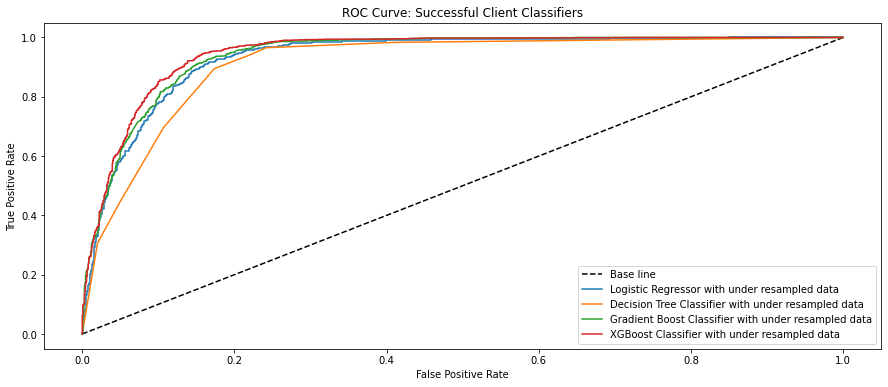

In [37]:
visualize_ROC_curves(y_under_test,y_under_test_pred_proba_df)

In [35]:
#visualize_RR_curves(y_under_test,y_under_test_pred_proba_df)
#Recall - Precision curve

### O P T I M A L    model

In [38]:
## init the optimal model
optimal_model = XGBClassifier(n_estimators=1000, learning_rate=0.003, use_label_encoder = False)
optimal_name = 'XGBClassifier on undersampled data'
X_opt_train = X_under_train
X_opt_test = X_under_test
y_opt_train = y_under_train
y_opt_test = y_under_test

optimal_model.fit(X_opt_train,y_opt_train)
y_opt_test_pred = optimal_model.predict(X_opt_test)

[17:27:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [39]:
# # ghi modelvào file pickle
# with open("model/pkl_model.pkl","wb") as f:
#     pickle.dump(optimal_model,f)

In [40]:
## Hệ số mô hình tối ưu
features = [i for i in process_mkt_df.columns.values.tolist() if i!= target]
opt_model_coef = pd.Series(data = optimal_model.feature_importances_, index = features, name = optimal_name)
opt_model_coef.sort_values(ascending = False)
## The coefficients of the optimal model

nr.employed       0.391450
duration          0.143611
cons.conf.idx     0.126333
emp.var.rate      0.087920
euribor3m         0.053499
month             0.023871
pdays             0.022673
education         0.018252
cons.price.idx    0.017982
poutcome          0.017578
day_of_week       0.014855
previous          0.013387
contact           0.011078
age               0.010709
campaign          0.009400
default           0.008900
job               0.008032
marital           0.007194
housing           0.006840
loan              0.006435
Name: XGBClassifier on undersampled data, dtype: float32

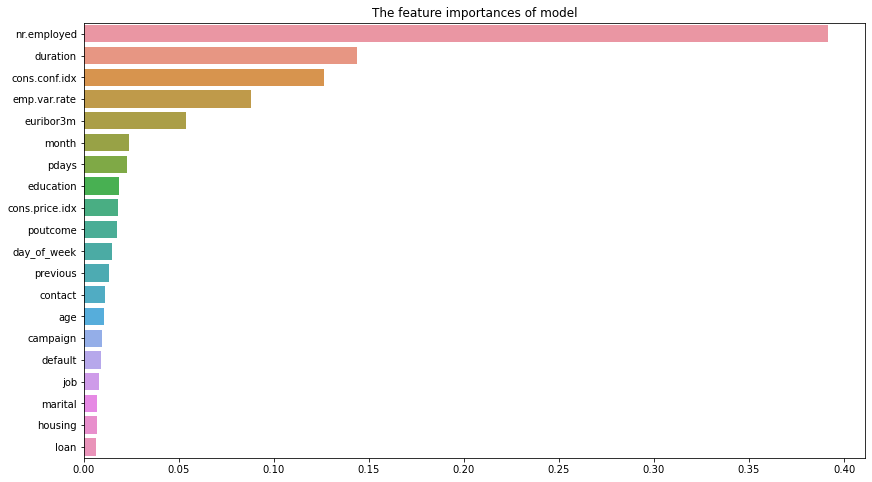

In [41]:
## Visualize feature importances of the optimal model
plt.figure(figsize = (14,8))
sns.barplot(x = opt_model_coef.sort_values(ascending = False).values , y = opt_model_coef.sort_values(ascending = False).index)
plt.title('The feature importances of model')
plt.show()


### O P T I M A L    ROI

In [42]:
### Real R O I trên tập Undersampled Test: X_opt_test
## ROI = roi_per_success * # of sales - cost_per_call * # of calls

cost_per_call = 10
roi_per_success = 20

number_client = len(y_opt_test)
real_roi = get_real_roi(y_opt_test,cost_per_call,roi_per_success)
pred_roi = get_pred_roi(y_opt_test, y_opt_test_pred)

print('The gained ROI when predicting for {} clients'.format(number_client))
print('The real revenue: '+str(real_roi))
print('The predicted revenue: '+str(pred_roi))
print('The ROI: '+str(pred_roi - real_roi))

The gained ROI when predicting for 2784 clients
The real revenue: -40
The predicted revenue: 10890
The ROI: 10930


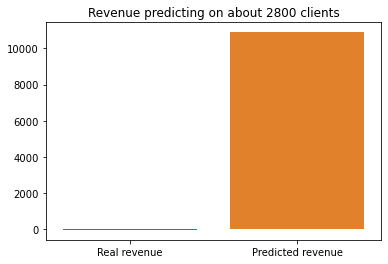

In [43]:
## visualize roi:

rois = [real_roi, pred_roi]
type_roi = ['Real revenue', 'Predicted revenue']
sns.barplot(y = rois , x = type_roi)
plt.title('Revenue predicting on about 2800 clients')
plt.show()


### R E S E A R C H   Decision tree

In [55]:
## init the research model
tree_model = DecisionTreeClassifier(criterion='gini', max_depth=3, random_state=0)
tree_name = 'Decision Tree Classifier'
X_tree_train = X_under_train
X_tree_test = X_under_test
y_tree_train = y_under_train
y_tree_test = y_under_test

tree_model.fit(X_tree_train,y_tree_train)
y_tree_test_pred = tree_model.predict(X_tree_test)

In [56]:
# # ghi modelvào file pickle
# with open("model/pkl_decisionT_model.pkl","wb") as f:
#     pickle.dump(optimal_model,f)

In [82]:
## Hệ số tree decision
features = [i for i in process_mkt_df.columns.values.tolist() if i!= target]
tree_model_coef = pd.Series(data = tree_model.feature_importances_, index = features, name = tree_name)
tree_model_coef = tree_model_coef[tree_model_coef > 0]
tree_model_coef.sort_values(ascending = False)
## The coefficients of the optimal model

duration         0.579650
nr.employed      0.275821
euribor3m        0.081684
cons.conf.idx    0.062846
Name: Decision Tree Classifier, dtype: float64

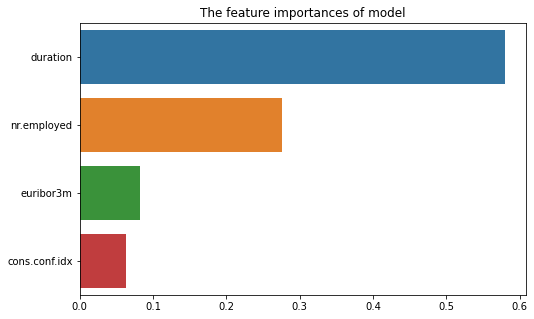

In [84]:
## Visualize feature importances of the tree model
plt.figure(figsize = (8,5))
sns.barplot(x = tree_model_coef.sort_values(ascending = False).values , y = tree_model_coef.sort_values(ascending = False).index)
plt.title('The feature importances of model')
plt.show()

### V I S U A L I Z E Decision Tree

In [89]:
# !pip install dtreeviz

In [103]:
from dtreeviz.trees import *
viz = dtreeviz(tree_model, 
               x_data=X_tree_train,
               y_data=y_tree_train,
               target_name='class',
               feature_names=features, 
               class_names=[0,1], 
               title="Decision Tree - Banking Tele-marketing data")
viz

ExecutableNotFound: failed to execute ['dot', '-Tsvg', '-o', 'C:\\Users\\HARANG~1\\AppData\\Local\\Temp\\DTreeViz_14588.svg', 'C:/Users/HARANG~1/AppData/Local/Temp\\DTreeViz_14588'], make sure the Graphviz executables are on your systems' PATH

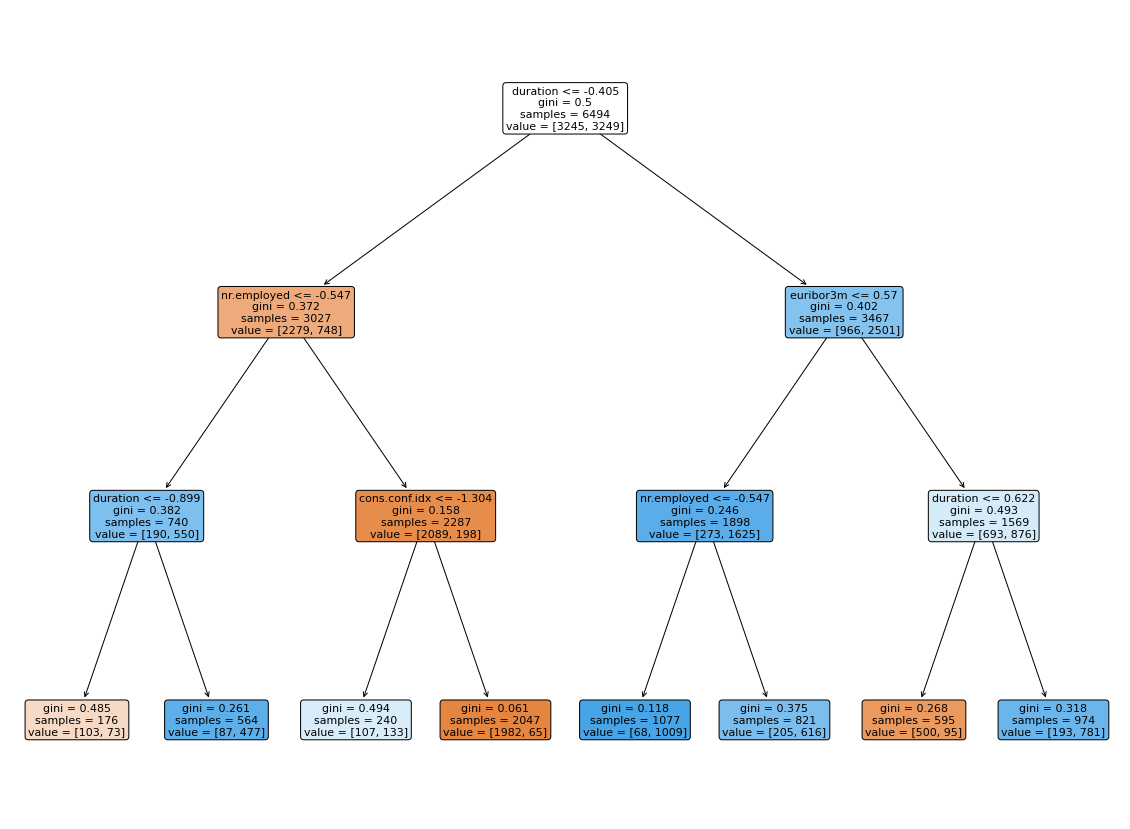

In [101]:
# from sklearn import tree
plt.figure(figsize=(20,15))
tree.plot_tree(tree_model,feature_names = features,rounded=True, filled = True);

### D E C I S I O N T R E E   ROI

In [69]:
cost_per_call = 10
roi_per_success = 20

number_client = len(y_tree_test)
tree_real_roi = get_real_roi(y_tree_test,cost_per_call,roi_per_success)
tree_pred_roi = get_pred_roi(y_tree_test, y_tree_test_pred)

print('The gained ROI when predicting for {} clients'.format(number_client))
print('The real revenue: '+str(tree_real_roi))
print('The predicted revenue: '+str(tree_pred_roi))
print('The ROI: '+str(tree_pred_roi - tree_real_roi))

The gained ROI when predicting for 2784 clients
The real revenue: -40
The predicted revenue: 10010
The ROI: 10050


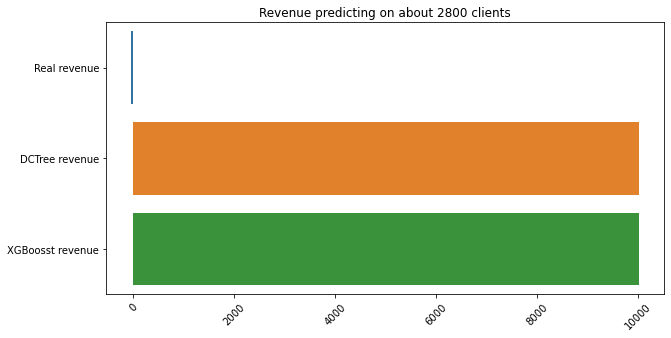

In [79]:
## visualize roi:

tree_rois = [real_roi, tree_pred_roi,pred_roi]
type_roi = ['Real revenue', 'DCTree revenue','XGBoosst revenue']
plt.figure(figsize = (10,5))
sns.barplot(x = tree_rois , y = type_roi)
plt.title('Revenue predicting on about 2800 clients')
plt.xticks(rotation = 45)
plt.show()

In [ ]:
# https://www.miai.vn/2021/01/18/k-fold-cross-validation-tuyet-chieu-train-khi-it-du-lieu/
